# Bernoulli Error
The Bernoulli distribution has the property of have a variance of $p(1-p)$. Therefore the standard error of $\hat{p}$ can be estimated knowing only $\hat{p}$ and $n$, $SE = \sqrt{\frac{\hat{p}(1-\hat{p})}{n}}$. This is for example widely used in calculating the significance of A/B tests, where one is interested in the difference $\delta$ between two parameters $p_1$ and $p_2$. The standard error of $\hat{\delta} = \hat{p}_2 - \hat{p}_1$ then can be estimated using $SE = \sqrt{\frac{\hat{p}_1(1-\hat{p}_1)}{n_1} + \frac{\hat{p}_2(1-\hat{p}_2)}{n_2}}$.

However, what if the true $p$ is not equal for all subjects in the population? $\hat{p}$ will still be an unbiased estimate of $E(p)$, but what about the standard deviation of the true $p_i$'s, ${\sigma_p}$? It seems counterintuitive that we will always have the same error (i.e. uncertainty) for each  $\hat{p}$ and $n$, irrespective of ${\sigma_p}$.

Let's find out whether this in fact influences your error.

### Don't forget to select your venv interpreter!
Install all the packages in the first cell

In [1]:
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install scipy
!{sys.executable} -m pip install seaborn

In [2]:
from IPython.display import Latex, Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import bernoulli, norm, binom

In [3]:
map_p = np.vectorize(lambda x, p_low, p_high: p_high if x == 1 else p_low, otypes=[np.float])
    
def sample_random_p(n, share_high, p_low, p_high):
    p = bernoulli.rvs(share_high, size=n)
    p = map_p(p, p_low, p_high)
    return p
    
def simulate_converted_users(p):
    x = bernoulli.rvs(p)
    converted = sum(x)
    return converted

In [4]:
p = sample_random_p(100, 0.5, 0, 0.8)
print(p)
unique, counts = np.unique(p, return_counts=True)

print(np.asarray((unique, counts)).T)
print(simulate_converted_users(p))
print(simulate_converted_users([0.2] * 10))


[0.  0.8 0.  0.  0.8 0.8 0.  0.  0.8 0.8 0.  0.8 0.  0.8 0.8 0.  0.  0.8
 0.8 0.8 0.8 0.8 0.  0.8 0.8 0.8 0.  0.8 0.  0.8 0.8 0.  0.  0.  0.8 0.
 0.  0.  0.8 0.8 0.  0.  0.8 0.8 0.  0.  0.  0.  0.  0.8 0.8 0.8 0.  0.8
 0.  0.  0.  0.  0.8 0.  0.  0.  0.  0.  0.  0.  0.8 0.8 0.  0.  0.  0.8
 0.  0.8 0.  0.8 0.  0.  0.  0.  0.8 0.  0.8 0.8 0.  0.8 0.8 0.8 0.  0.
 0.  0.  0.8 0.  0.8 0.  0.8 0.  0.  0.8]
[[ 0.  56. ]
 [ 0.8 44. ]]
40
1


## Create a function to perform the t-test

In [5]:
# def run_t_test_ab_test(users_a, users_b, converted_a, converted_b, alpha):
#     p_a_hat = converted_a / users_a
#     p_b_hat = converted_b / users_b
#     var_p_a_hat = p_a_hat * (1-p_a_hat)
#     var_p_b_hat = p_b_hat * (1-p_b_hat)
#     diff = p_b_hat - p_a_hat
#     diff_std_rerror = np.power((var_p_a_hat/users_a + var_p_b_hat/users_b), 0.5)
#     t_stat = diff / diff_std_rerror
#     p_val = norm.cdf(t_stat)
#     sign_bound = norm.ppf(1-alpha/2) * diff_std_rerror
#     power = 1 - norm.cdf(sign_bound, loc=diff, scale=diff_std_rerror)
#     return diff, p_val, power

def compute_diff_and_std_error(users, converted, null_hypothesis_mean):
    p_hat = converted / users
    var_p_hat = p_hat * (1-p_hat) / users
    diff = p_hat - null_hypothesis_mean
    std_error = np.power(var_p_hat, 0.5)
    t_stat = diff / std_error
    p_val = norm.cdf(t_stat)
    return diff, std_error, p_val

## Run the analysis
Now you have everything ready to start analysis. Run simulations with different levels of noise in p en compare

/home/rubenmak/PycharmProjects/datasciencemaster___ghost_ads___shared/venv/ghost_ads/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
/home/rubenmak/PycharmProjects/datasciencemaster___ghost_ads___shared/venv/ghost_ads/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in double_scalars


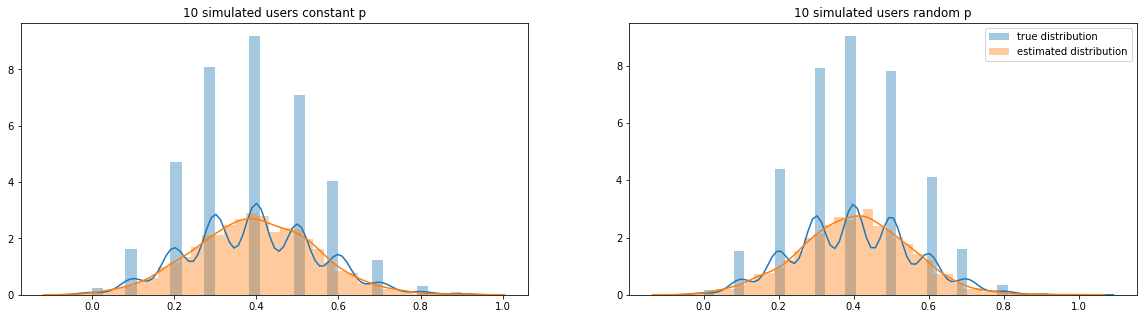

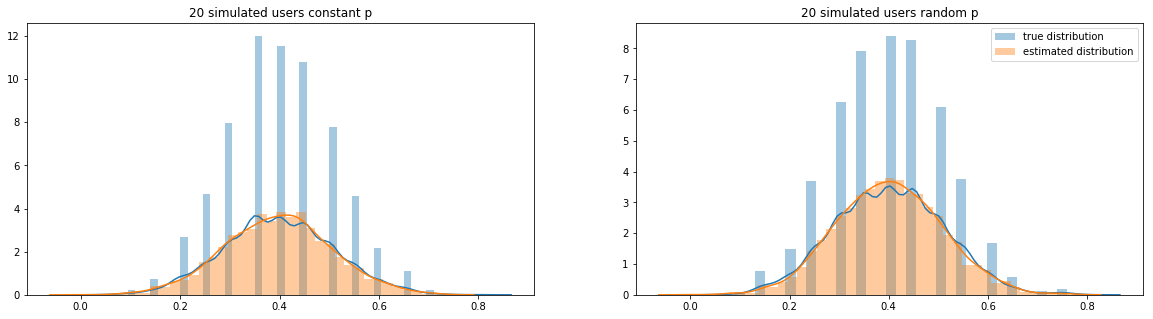

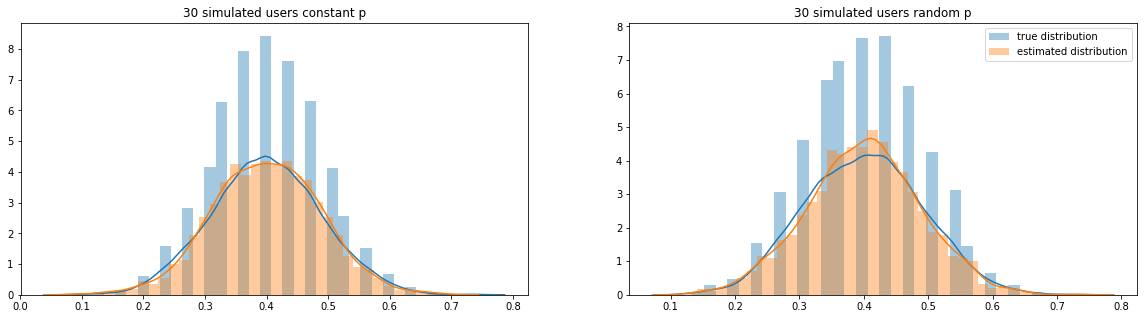

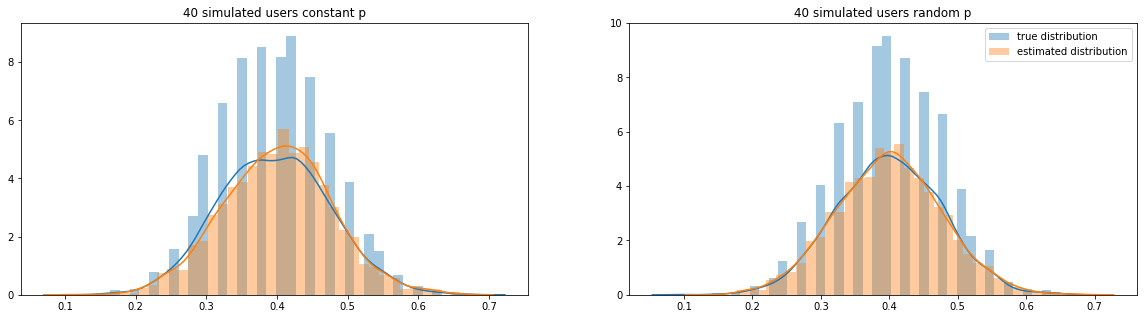

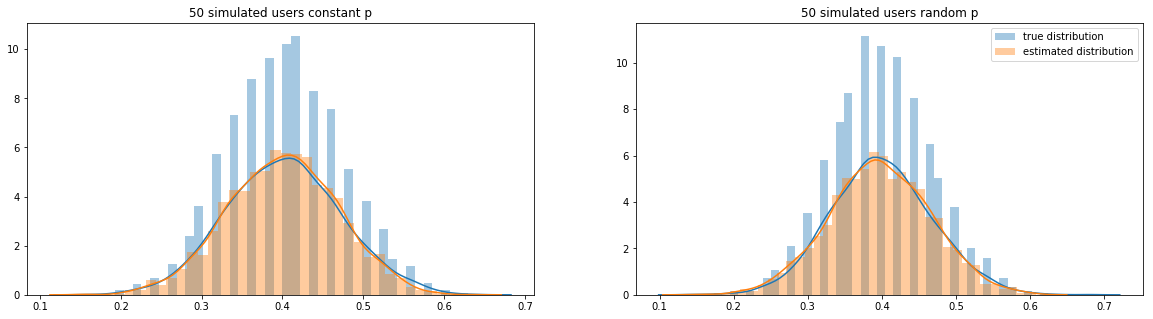

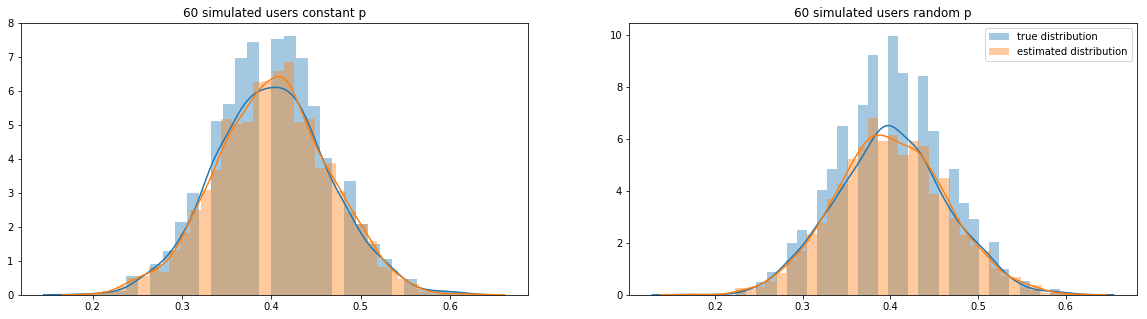

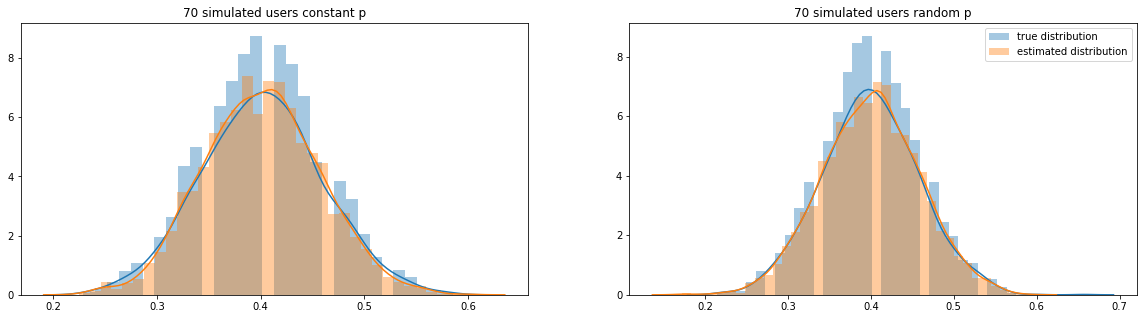

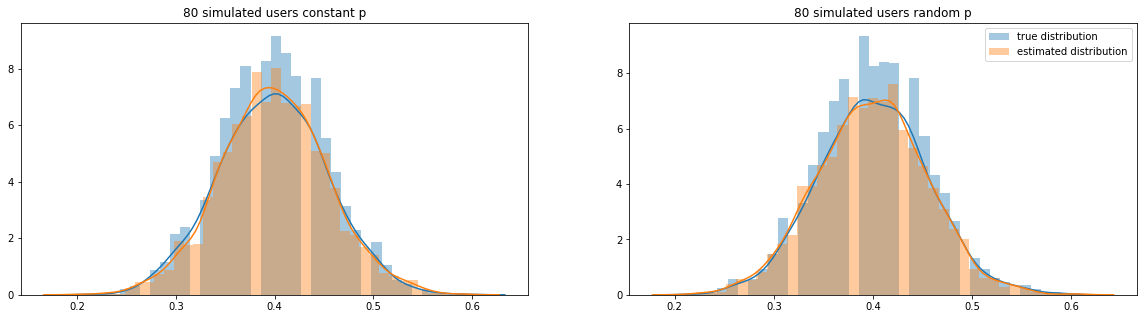

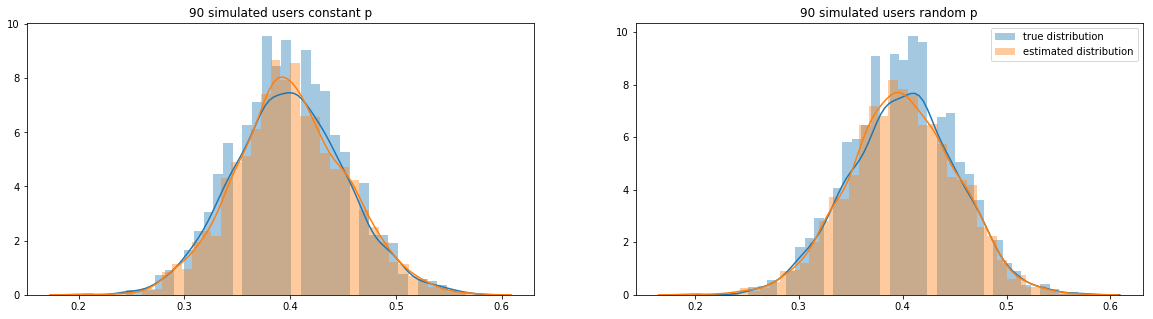

In [8]:
SIMULATIONS = 3000
p_low = 0.
p_high = 0.8
share_high = 0.5
p_constant = share_high * p_high + (1-share_high) * p_low

null_hypothesis_mean = 0.

Ns = range(10, 100, 10)

sim_diff_constant_p = []
est_diff_constant_p = []
sim_diff_random_p = []
est_diff_random_p = []

def run_simulations_for_n(N, SIMULATIONS):
    
    diff_constant_p = []
    std_error_constant_p = []
    diff_random_p = []
    std_error_random_p = []
    
    for i in range(SIMULATIONS):
        converted = simulate_converted_users([p_constant] * N)
        diff, std_error, p_val = compute_diff_and_std_error(N, converted, 0)
        diff_constant_p += [diff]
        std_error_constant_p += [std_error]
  
        
        p_random = sample_random_p(N, share_high, p_low, p_high)
        converted = simulate_converted_users(p_random)
        diff, std_error, p_val = compute_diff_and_std_error(N, converted, 0)
        diff_random_p += [diff]
        std_error_random_p += [std_error]


    return (diff_constant_p,
            std_error_constant_p,
            diff_random_p,
            std_error_random_p)

for N in Ns:
    (diff_constant_p,
    std_error_constant_p,
    diff_random_p,
    std_error_random_p) = run_simulations_for_n(N, SIMULATIONS)
    
    f, axes = plt.subplots(1, 2, figsize=(20,5))
    
    sns.distplot(np.array(diff_constant_p), label='true distribution', ax=axes[0])
    sns.distplot(norm.rvs(p_constant, np.mean(std_error_constant_p), SIMULATIONS), label='estimated distribution', ax=axes[0])
    axes[0].title.set_text(str(N) + ' simulated users constant p')
    
    sns.distplot(np.array(diff_random_p), label='true distribution', ax=axes[1])
    sns.distplot(norm.rvs(p_constant, np.mean(std_error_random_p), SIMULATIONS), label='estimated distribution', ax=axes[1])
    axes[1].title.set_text(str(N) + ' simulated users random p')
    plt.legend()
    plt.show()

### Conclusion
This illustrates that $N(\hat{p}, \sqrt{\frac{\hat{p}(1-\hat{p})}{n}}))$ gives a good estimate of the true distribution of $\bar{p}$ of a Bernouli distributed variable, even if the underlying $p$ is noisy.